--------------------------------------------------------------------------------------------------------------
### <b>Table of Contents</b>

0. Background

1. Import functions

2. Load and explore data

3. Split and transform data

4. Train, evaluate, and save model

5. Identify important customer segments and features<br>
    5-1. Examine distributions of numeric variables<br>
    5-2. Perform chi-square test on non-numeric variables<br>
    5-3. Analyze proportional value counts for each variable<br>
    5-4. Analyze feature importances<br>
    5-5. Analyze day and month variables<br>
    &emsp; 5-5-1. Day<br>
    &emsp; 5-5-2. Month

6. Conclusion<br>
    6-1. Prediction accuracy<br>
    6-2. Customer segments<br>
    6-3. Important features<br>
    6-4. Application
--------------------------------------------------------------------------------------------------------------

### <b>0. Background</b>

This project is for a startup providing machine learning solutions in the European banking market. The goal is to design a robust machine learning system that leverages call center data to predict customer subscriptions. Client segmentation and feature importance will also be examined to ultimately improve the success rate of marketing calls to customers offering product subscriptions.

The call center data consists of 40000 rows (i.e., 40000 customers) and 13 columns (i.e., information about each customer) including the target variable 'y' indicating whether or not the client subscribed to the product.

More details can be found in <a href="https://github.com/henryhyunwookim/Term-Deposit-Marketing#readme">README</a>.

### <b>1. Import functions</b>

In [50]:
# Load functions
from utils.load import pd, load_data
from utils.plot import plt, sns, plot_histograms, plot_distributions, plot_bars, plot_pies, plot_timeseries
from utils.split import split_data
from utils.transform import pivot_data, resample_data, normalize_data, numeric_to_interval, concat_counts_df, get_numeric_columns
from utils.models import XGBClassifier
from utils.evaluate import cross_val_score, RepeatedStratifiedKFold, get_sorted_dict, group_items
from utils.statistical_test import hypothesis_test, run_chi_tests
from utils.predict import transform_fit_predict

import warnings
warnings.simplefilter(action='ignore', category=(FutureWarning, RuntimeWarning)) # UserWarning

### <b>2. Load and explore data</b>

In [51]:
file_name = "term-deposit-marketing-2020.csv"
folder_name = "data"
data = load_data(file_name=file_name,
                folder_name=folder_name)
print(data.head(), "\n")
print(data.info(), "\n")
data.describe()

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign   y  
0  unknown    5   may       261         1  no  
1  unknown    5   may       151         1  no  
2  unknown    5   may        76         1  no  
3  unknown    5   may        92         1  no  
4  unknown    5   may       198         1  no   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object


,age,balance,day,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,1274.277550,16.017225,254.824300,2.882175
std,9.641776,2903.769716,8.278127,259.366498,3.239051
min,19.000000,-8019.000000,1.000000,0.000000,1.000000
25%,33.000000,54.000000,8.000000,100.000000,1.000000
50%,39.000000,407.000000,17.000000,175.000000,2.000000
75%,48.000000,1319.000000,21.000000,313.000000,3.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000


The data set consists of different data types.

Convert the type of "day" from int64 to object/categorical.

In [52]:
data['day'] = data['day'].astype(str)

Take a look at the distribution of the target variable "y" and dependent variables that are numeric.

Distribution of target y and dependent variables:


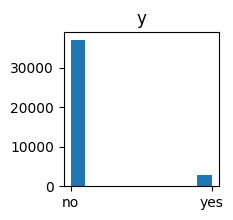

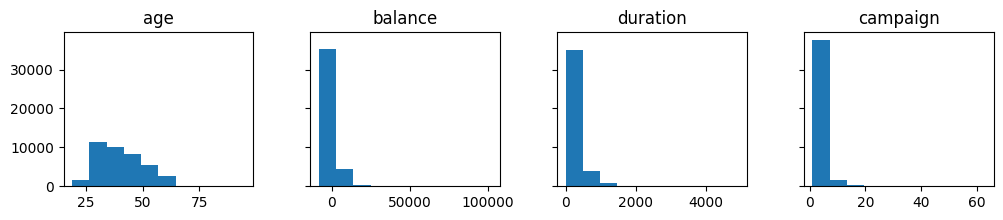

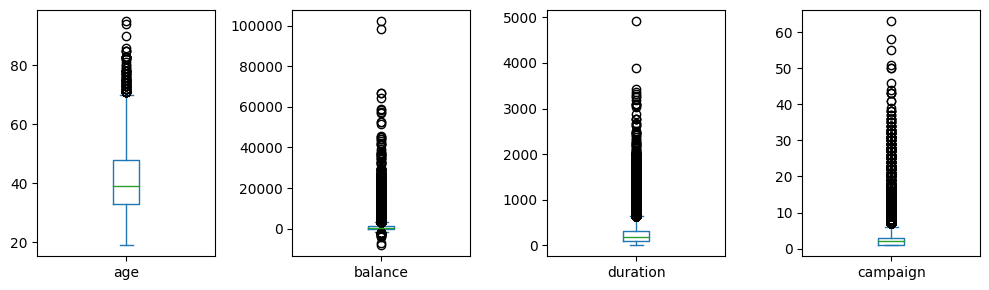

In [53]:
plot_histograms(data=data,
                target="y", target_figsize=(2,2),
                dependent_layout=(1,4), dependent_figsize=(12, 2),
                include_boxplots=True, boxplot_figsize=(10, 3))

Firt of all, the target class is highly imbalanced. Let's look at the value counts and proportions.

In [54]:
print(data["y"].value_counts())
print()
print(data["y"].value_counts() / data["y"].value_counts().sum())

no     37104
yes     2896
Name: y, dtype: int64

no     0.9276
yes    0.0724
Name: y, dtype: float64


The minority class (i.e. "yes") only accounts for about 7% of the target variable, but it still has close to 3K instances/rows, which could be enough for model tranining.<br>
We can try downsampling, upsampling, of both, but this will need to be done <b>after</b> separating test data from the original data set to prevent data leakage.

Secondly, the numeric variables are highly skewed to the right, meaning there are outliers on the right side, which is confirmed by the boxplots (i.e. there are data points way above the box in each plot).<br>
Also, they are in widely different scales (e.g. the scales of the age and balance variables are very different), which will not be helpful in model training and evaluation.<br>
For these reasons, the numeric variables will be normalized using sklearn's StandardScaler after splitting the data into train and test sets.

Lastly, in addition to the numeric variables we've looked at, we also have categorical variables. Those categorical variables will need to be converted into numeric, including the target variable, so that machine learning models can understand the data. Panda's get_dummies method will be used for that operation.<br>
* The target variable will be manually converted from "no" to 0 and from "yes" to 1 without using the encoder so that "no" would not be converted to 1, which is not intuitive in practice and might cause misunderstanding.

In [55]:
X, y = pivot_data(data=data, target="y", binary_target_value="yes")
X.describe()

,age,job_admin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,duration,campaign
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.00000,40000.000000,...,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,40.544600,0.112075,0.234575,0.035125,0.027175,0.204150,0.035925,0.035350,0.09775,0.013100,...,0.057400,0.029400,0.159500,0.118350,0.006450,0.338300,0.089950,0.002000,254.824300,2.882175
std,9.641776,0.315463,0.423738,0.184098,0.162595,0.403084,0.186106,0.184665,0.29698,0.113704,...,0.232608,0.168927,0.366146,0.323026,0.080053,0.473137,0.286114,0.044677,259.366498,3.239051
min,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,1.000000
50%,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,175.000000,2.000000
75%,48.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,313.000000,3.000000
max,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4918.000000,63.000000


### <b>3. Split and transform data</b>
Before performing any transformation to the data, split it into train and test sets first.

In [56]:
test_size = 0.2
random_state = 1
X_train, X_test, y_train, y_test = \
    split_data(X=X, y=y, test_size=test_size, stratify=y, random_state=random_state)

In [57]:
y_train.value_counts()

0    29683
1     2317
Name: y, dtype: int64

After the split, resample only the train data to deal with the imbalance of the target variable - the test data shouldn't be resampled because resampling or any similar type of operation/manipulation to the test data can potentially introduce data leakage or bias toward training data (as resampling will make the characteristics of the test data more similar to the training data, which could further lead to overfitting). It essentially makes it difficult to simulate the real-world performance of the model since unseen data in the real world would not be resampled.
Simply put, not making any changes to the test data will help ensure a more accurate and unbiased performance evaluation of the model.

We could try both upsampling and downsampling techniques to see which one gives us better results, but for now, we will downsample since the minority class already has more than 2k instances.

In [58]:
X_train_balanced, y_train_balanced = resample_data(X_train, y_train, method="downsample")
y_train_balanced.value_counts()

0    2317
1    2317
Name: y, dtype: int64

Next, normalize the dependent variables using sklearn's StandardScaler as mentioned above so that they will be on the same scale.

In [59]:
X_train_normalized, X_test_normalized = normalize_data(X_train_balanced, X_test, method="standard")

### <b>4. Train, evaluate, and save model</b>

Since preprocessing steps have been completed, it's time to train XGBClassifier using the train data and cross-validate prediction scores on the test data.

Hypothesis test for XGBClassifier
Null hypothesis - Mean test score is not significantly different from 0.81 at alpha=0.05.

Result:
Rejected the null hypothesis - Mean test score is greater than 0.81 at alpha=0.05.



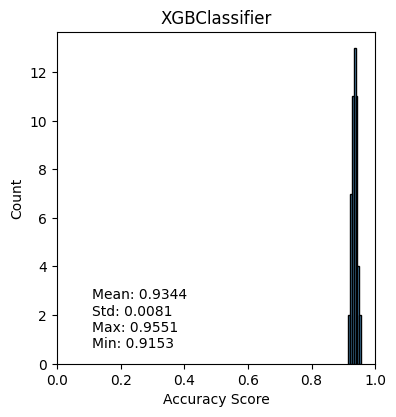

In [60]:
xgb_clf = XGBClassifier(seed=random_state)
xgb_clf.fit(X_train_normalized, y_train_balanced)
scores = cross_val_score(xgb_clf, X_test_normalized, y_test, scoring='roc_auc',
                         cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10))
hypothesis_test(values=scores, target=0.81, alpha=0.05, model=xgb_clf, figsize=(5,5))

The prediction accuracy was over 90% with a small standard deviation. Now go through the same processes again but with varying data transformation steps to see how prediction accuracies change.

In [61]:
xgb_clf = XGBClassifier(seed=random_state)
transform_fit_predict(X_train, y_train, X_test, y_test,
                      resample=False, resampling_method=None,
                      normalize=False, normalize_method=None,
                      model=xgb_clf,
                      cv_n_splits=5, cv_n_repeats=10,
                      method='No resampling nor normalizing scales',
                      random_state=random_state)

No resampling nor normalizing scales: 0.9349719425280146


Normalizing scales turns out to be not significantly impactful, probably because there are only 4 numeric variables to normalize and other dependent variables are all binary (i.e. either 0 or 1). Having said that, the mean prediction accuracy was better with normalization.<br>
<br>
Now check whether upsampling or downsampling results in better prediction accuracies.

In [62]:
transform_fit_predict(X_train, y_train, X_test, y_test,
                      resample=True, resampling_method='upsample',
                      normalize=True, normalize_method='standard',
                      model=xgb_clf,
                      cv_n_splits=5, cv_n_repeats=10,
                      method='Upsampling with normalizing scales',
                      random_state=random_state)

Upsampling with normalizing scales: 0.935785250844996


In [63]:
transform_fit_predict(X_train, y_train, X_test, y_test,
                      resample=True, resampling_method='downsample',
                      normalize=True, normalize_method='standard',
                      model=xgb_clf,
                      cv_n_splits=5, cv_n_repeats=10,
                      method='Downsampling with normalizing scales',
                      random_state=random_state)

Downsampling with normalizing scales: 0.9342510058683938


Based on this little experiment above, upsampling with standard normalization produced the highest mean prediction accuracy score. Hence, save the model trained with an upsampled target variable and normalized dependent variables.<br>
<br>
Lastly, try the cross-validation on the test data 100 times instead of 10 to give more statistical power to the result.

In [64]:
transform_fit_predict(X_train, y_train, X_test, y_test,
                      resample=True, resampling_method='upsample',
                      normalize=True, normalize_method='standard',
                      model=xgb_clf,
                      cv_n_splits=5, cv_n_repeats=100,
                      method='Upsampling with normalizing scales',
                      random_state=random_state,
                      save_model=True)

Trained model saved: d:\OneDrive\GitHub\Apziva\Term-Deposit-Marketing
Upsampling with normalizing scales: 0.9351148071929758


The average 5-fold cross-validation accuracy score was still above 81.<br>

Since we have already achieved the target accuracy score, no model selection or hyperparameter tuning would be necessary for the time being.

### <b>5. Identify important customer segments and features</b>

We are also interested in finding customers who are more likely to buy the investment product. We are going to look at the distribution of numeric variables, perform chi-square tests using non-numeric variables, and analyze the proportion of the values of each variable to determine more important customer segments and features that our client should prioritize.

We could choose to look at the rows where the 'y' column value is 'yes', but that would be less meaningful if the characteristic of subscribers and non-subscribers are similar. For this reason, we will look at the two groups at the same time to understand them holistically.

Before moving on, group the columns into numeric and non-numeric for different types of analyses.

In [65]:
numeric_columns, non_numeric_columns = get_numeric_columns(data, cols_to_exclude=["y"])

##### <b>5-1. Examine distributions of numeric variables</b>

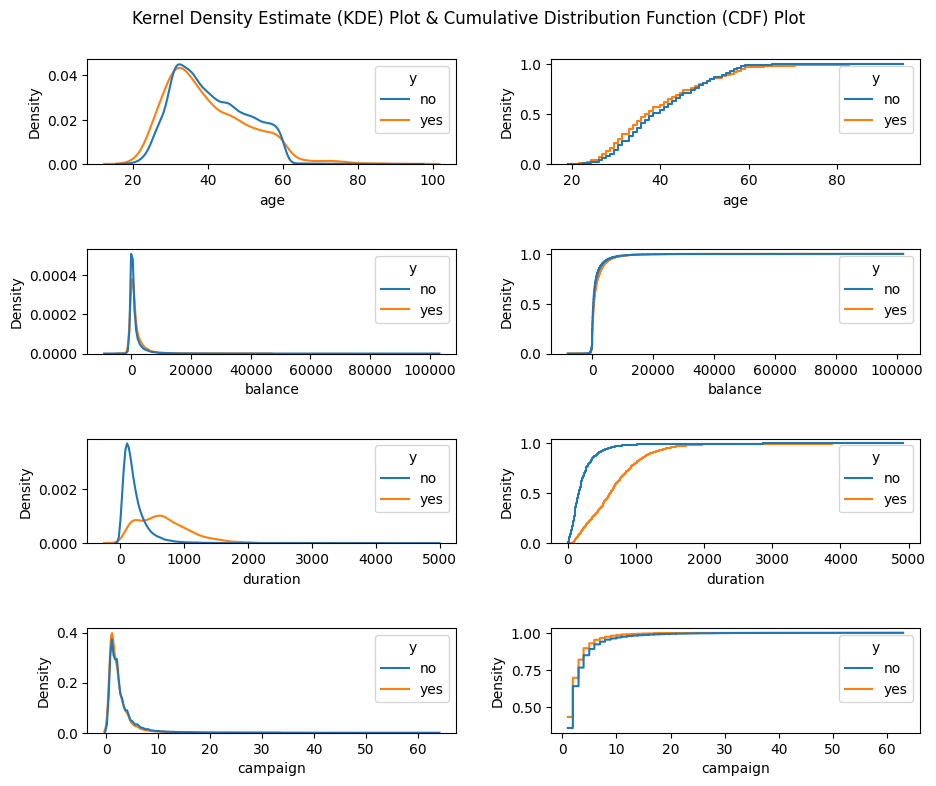

In [66]:
plot_distributions(data=data, columns=numeric_columns, hue_col="y")

- Customers who subscribed seem generally younger than those who didn't subscribe, but there are <b>proportionally a lot more subscribers over age 60</b>, which can be confirmed by running the two cells below - about 39% of customers over 60 subscribed, whereas only 7% from the younger age group subscribed.

In [67]:
age_over_60 = data[data.age>60]
age_over_60.y.value_counts() / age_over_60.y.count()

no     0.611111
yes    0.388889
Name: y, dtype: float64

In [68]:
age_less_than_60 = data[data.age<=60]
age_less_than_60.y.value_counts() / age_less_than_60.y.count()

no     0.929462
yes    0.070538
Name: y, dtype: float64

- The distributions of balance were not too different among people who subscribed and who didn't. Thus, looking at it in more details might not be very meaningful, although subscribers' balance seems slightly higher.

- The distributions of campaign might seem very similar between the two groups at first glance, but there are proportionally more subscribers with lower campaign values.

- The distributions of duration were widely different between subscribers and non-subscribers, which can be an indicator for identifying customers who have subscribed (or are more likely to subscribe), e.g. <b>longer last contact duration is more likely to lead to subscription.</b>
The following two cells confirm this - close to half of the customers subscribed when the last contact duration was longer than 10 minutes whereas it was even less than 4% when the duration was shorter than 10 minutes.

In [69]:
duration_over_10_mins = data[data.duration>600]
duration_over_10_mins.y.value_counts() / duration_over_10_mins.y.count()

no     0.544048
yes    0.455952
Name: y, dtype: float64

In [70]:
duration_less_than_10_mins = data[data.duration<=600]
duration_less_than_10_mins.y.value_counts() / duration_less_than_10_mins.y.count()

no     0.962773
yes    0.037227
Name: y, dtype: float64

##### <b>5-2. Perform chi-square test on non-numeric variables</b>

Convert day and month columns to datetime for plotting, and run a chi-square test for each variable to see if they are highly related to the target variable, or in other words whether they are relevant to subscription status.

In [71]:
non_numeric_df = data[non_numeric_columns+['y']]
pd.set_option('mode.chained_assignment', None)
non_numeric_df['day'] = pd.to_datetime(non_numeric_df['day'], format='%d').dt.day
non_numeric_df['month'] = pd.to_datetime(non_numeric_df['month'], format='%b').dt.month

In [72]:
run_chi_tests(data=non_numeric_df, target='y', significance_level=0.05,
              plot=False,
              goodness_of_fit_test=False)

,Independent Variable,Chi-square,P-value,Null Hypothesis,Reject Null Hypothesis at alpha=0.05?,Variable
8,NaN,1523.706662,0.000000e+00,month and y are independent of each other,Yes,month
7,NaN,418.635958,4.733110e-70,day and y are independent of each other,Yes,day
6,NaN,323.007275,7.242047e-71,contact and y are independent of each other,Yes,contact
0,NaN,149.750422,1.676135e-26,job and y are independent of each other,Yes,job
1,NaN,135.898096,3.091031e-30,marital and y are independent of each other,Yes,marital
4,NaN,117.669421,2.048343e-27,housing and y are independent of each other,Yes,housing
2,NaN,96.674415,8.061911e-21,education and y are independent of each other,Yes,education
5,NaN,38.196872,6.395487e-10,loan and y are independent of each other,Yes,loan
3,NaN,1.545943,2.137353e-01,default and y are independent of each other,No,default


As we can see from the chi-square values and p-values, all variables except for 'default' were not independent of the target variable y at the significance level of 0.05, meaning they are somehow related to the target and would be relevant/helpful in predicting the target.

Since day and month variables turn out to be the most important, they will be looked into separately in section 4.5.

##### <b>5-3. Analyze proportional value counts for each variable</b>

Convert numeric column values into intervals so that there will only be 10 unique values for each column/variable - otherwise there will be too many individual value counts for those numeric columns. For the same reason, convert the 'day' column back from str to int so that we can create intervals.

In [73]:
data_interval_df = data.copy()
data_interval_df['day'] = data_interval_df['day'].astype('int')
for num_col in numeric_columns + ['day']:
    data_interval_df = numeric_to_interval(data=data_interval_df, column=num_col, n_intervals=10)
data_interval_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,"(57.0, 64.6]",management,married,tertiary,no,"(-8019.0, 2995.6]",yes,no,unknown,"(4.0, 7.0]",may,"(0.0, 491.8]",NaN,no
1,"(41.8, 49.4]",technician,single,secondary,no,"(-8019.0, 2995.6]",yes,no,unknown,"(4.0, 7.0]",may,"(0.0, 491.8]",NaN,no
2,"(26.6, 34.2]",entrepreneur,married,secondary,no,"(-8019.0, 2995.6]",yes,yes,unknown,"(4.0, 7.0]",may,"(0.0, 491.8]",NaN,no
3,"(41.8, 49.4]",blue-collar,married,unknown,no,"(-8019.0, 2995.6]",yes,no,unknown,"(4.0, 7.0]",may,"(0.0, 491.8]",NaN,no
4,"(26.6, 34.2]",unknown,single,unknown,no,"(-8019.0, 2995.6]",no,no,unknown,"(4.0, 7.0]",may,"(0.0, 491.8]",NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,"(49.4, 57.0]",technician,married,tertiary,no,"(-8019.0, 2995.6]",no,no,cellular,"(1.0, 4.0]",jun,"(0.0, 491.8]",NaN,no
39996,"(26.6, 34.2]",management,single,tertiary,no,"(2995.6, 14010.2]",no,no,cellular,"(1.0, 4.0]",jun,"(0.0, 491.8]","(1.0, 7.2]",yes
39997,"(49.4, 57.0]",admin,divorced,secondary,no,"(-8019.0, 2995.6]",no,no,cellular,"(1.0, 4.0]",jun,"(0.0, 491.8]",NaN,yes
39998,"(26.6, 34.2]",management,married,tertiary,no,"(-8019.0, 2995.6]",no,no,cellular,"(1.0, 4.0]",jun,"(0.0, 491.8]",NaN,no


Now split the data frame into two, where one only contains subscribers and the other only non-subscribers.

In [74]:
subscribers_df = data_interval_df[data_interval_df['y'] =='yes'].reset_index(drop=True).drop(['y'], axis=1)
non_subscribers_df = data_interval_df[data_interval_df['y'] =='no'].reset_index(drop=True).drop(['y'], axis=1)

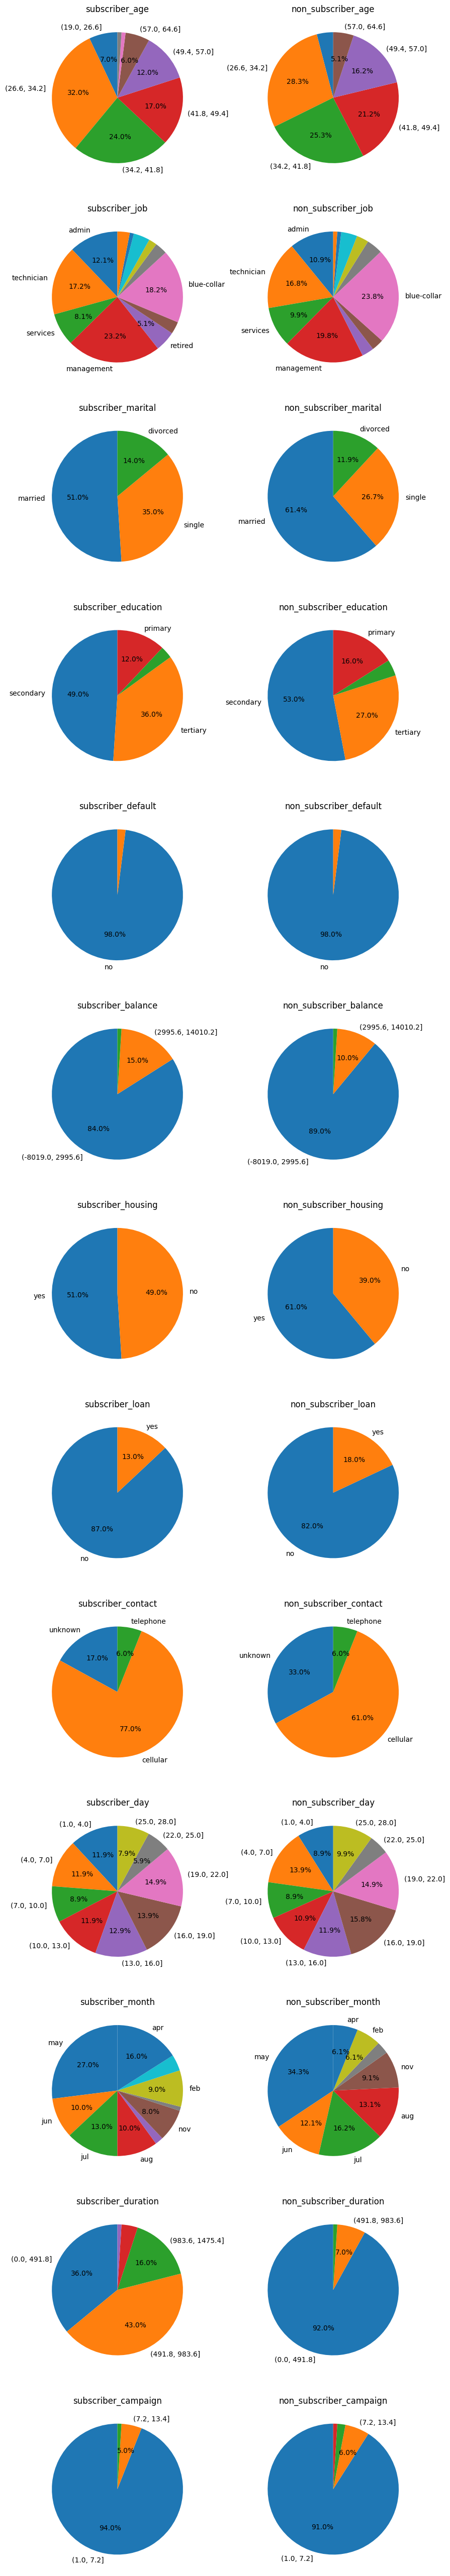

In [75]:
num_cols = data_interval_df.shape[1] - 1
fig, axes = plt.subplots(num_cols, 2, figsize=(9, 4*num_cols))
plt.tight_layout(pad=3)
for i, col in enumerate(data_interval_df.drop(['y'], axis=1).columns):
    for j in [0, 1]:
        ax = axes[i, j]
        counts_df = concat_counts_df(df1=subscribers_df, df1_name="subscriber",
                                    df2=non_subscribers_df, df2_name="non_subscriber",
                                    column=col)
        values = counts_df.values[j]
        labels = [col if val >= 0.05 else "" for col, val in zip(counts_df.columns, values)]
        plot_pies(values=values,
                  labels=labels,
                  ax=ax,
                  title=counts_df.index[j],
                  autopct=lambda x: ('%1.1f%%' % x) if x > 5 else '',
                  sort_values=False)

1. Age: There are proportionally more subscribers below 34.2 & over 64.6. Our client can choose to focus more on these age groups, for instance providing services that are more specific to these age groups, or put more effort into attracting more subscribers from the 'weak' age groups, that is between 34.2 and 64.6.

2. Job: The biggest gap between subscribers and non-subscribers comes from blue-collar customers - blue-collar customers account for 24% of non-subscribers, while they only account for 18% of subscribers. This means that blue-collar customers are less likely to subscribe. On the contrary, customers with management jobs are more likely to subscribe, which our client can focus more on (i.e. customers with management jobs account for 23% of the subscriber group while only accounting for 20% of the non-subscriber group).

3. Marital: Proportionally fewer married customers subscribed, whereas single and divorced subscribers account for almost half of all subscribers. Based on this, our client can put more emphasis on these groups while devising offerings that married customers would be interested in.

4. Education: As a whole, subscribers are more educated than non-subscribers, so our client can try to offer services that less educated people might be interested in, or strengthen offerings for more educated customers. In terms of the ratios between subscribers and non-subscribers, customers with tertiary education are most likely to subscribe (i.e. 9% point difference between the subscriber and non-subscriber groups with tertiary education; 36% vs. 27%).

5. Default: There's no or little proportional difference between subscribers and non-subscribers, thus it would not be very meaningful to look into it further, which was confirmed by the chi-square test earlier. If we see this trend for a longer period of time, we might want to stop collecting this piece of information from customers.

6. Balance: Average yearly balance of almost all customers were less than 14010.2 euros; about 1% of them were between 14010.2 and 25024.8 euro. It is clear that customers with an average yearly balance greater than 14010.2 are quite unlikely to subscribe; hence we can focus more on customers with a lower balance.

7. Housing: Almost half of the subscribers (49%) do not have a housing loan while less proportion of non-subscribers (39%) are without a housing loan. This indicates that customers without a housing loan are more likely to subscribe.

8. Loan: A smaller proportion of subscribers have a personal loan compared to the non-subscriber group, suggesting customers with a loan are less likely to subscribe - this in fact makes a lot of sense, so our client can focus less on attracting customers with a loan.

9. Contact: 77% of subscribers were contacted at their cellular phone, which was 16% point more than the non-subscriber group, which signifies that customers are more likely to subscribe when cellular is the means of contact. Thus it could be worth making an effort to obtain cellular phone numbers (and potentially other information that might be helpful) from the customers to attract more subscribers.

10. Day: The proportions are quite evenly distributed across different day groups. This will be looked into further in a later section.

11. Month: There are certain months with higher and lower proportions but it would make more sense to look at them as a time-series chart in a later section, together with the 'day' variable.

12. Duration: 92% of non-subscribers had the last contact that lasted for less than 491.8 seconds, which is about 8 minutes. It is clear that subscribers had longer last contact, thus we can further analyze what was communicated with the customers during those longer contacts and how that led to subscriptions.

13. Campaign: The proportions of different campaign ranges were similar between the subscriber and non-subscriber groups, but the number of contacts performed during this campaign for the client was less than 19.6 for almost all subscribers. From this, we can infer that contacting customers more than 19 times during a campaign would not lead to subscriptions. Also, 94% of subscribers were contacted less than 8 times, thus our client can also choose not to contact customers more than 8 times since those additional attempts are not very likely to attract more subscribers.

##### <b>5-4. Analyze feature importances</b>

Moving on, let's analyze feature importance scores from the XGBoost classifier that will tell us how important each feature was in predicting the target. Once identified, we can suggest our client focus more on those more importance features to attract more customers.

In [76]:
train_features = X.columns
feature_importances = xgb_clf.feature_importances_
sorted_dict = get_sorted_dict(keys=train_features, values=feature_importances)
sorted_dict

{'housing_yes': 0.12073225,
 'housing_no': 0.098711364,
 'contact_unknown': 0.08103521,
 'marital_divorced': 0.0693954,
 'month_aug': 0.052508138,
 'education_unknown': 0.038942207,
 'month_nov': 0.03715429,
 'month_jan': 0.036048904,
 'month_jul': 0.032264605,
 'duration': 0.031251248,
 'marital_single': 0.027679825,
 'education_primary': 0.026315618,
 'month_may': 0.024759345,
 'education_tertiary': 0.021002276,
 'loan_yes': 0.019863551,
 'marital_married': 0.016848357,
 'contact_telephone': 0.016519511,
 'month_apr': 0.01596044,
 'month_jun': 0.015170269,
 'education_secondary': 0.012625503,
 'month_feb': 0.011762482,
 'job_technician': 0.011556041,
 'job_management': 0.010632874,
 'job_blue-collar': 0.010617425,
 'loan_no': 0.010121628,
 'job_services': 0.009776811,
 'month_oct': 0.008501935,
 'job_unemployed': 0.006193685,
 'job_entrepreneur': 0.0058265678,
 'job_admin': 0.005605398,
 'contact_cellular': 0.0055558826,
 'job_housemaid': 0.005481512,
 'job_retired': 0.005481221,
 'j

It is difficult to quickly identify which variables/columns of the original data were more important in predicting the target variable due to a large number of features that were pivoted from the original features - 74 in total.

For this reason, group them back based to the original columns (e.g. group "housing_yes" and "housing_no" into "housing" and sum their feature importances) so that we have the same number of features (and their importance) of the original data, that is 13 excluding the target variable "y".

In [77]:
grouped_dict = group_items(_dict=sorted_dict, group_keys=data.drop(["y"], axis=1).columns)
grouped_dict

{'month': 0.2355789,
 'housing': 0.21944362,
 'marital': 0.11392358,
 'contact': 0.103110604,
 'education': 0.0988856,
 'job': 0.08197907,
 'day': 0.07733654,
 'duration': 0.031251248,
 'loan': 0.029985178,
 'age': 0.011928758,
 'campaign': 0.0034310434,
 'default': 0.0022777524,
 'balance': 0.0015008978}

The importance of the following features in predicting y was higher than 5%:

In [78]:
top_features = [k for k, v in grouped_dict.items() if v > 0.05]
top_features

['month', 'housing', 'marital', 'contact', 'education', 'job', 'day']

We are going to look at each of these features in more detail to identify what specific feature values would be strong indicators of a potential subscriber. We can come back to the plots from section 5.3. where the proportion of each feature value for subscriber and non-subscriber groups was looked at. Let's create the same bar plots and reiterate the findings here for convenience.
* The month and day columns will also be analyzed separately at the end as they cannot be treated exactly the same as other categorical features due to time elements in them.

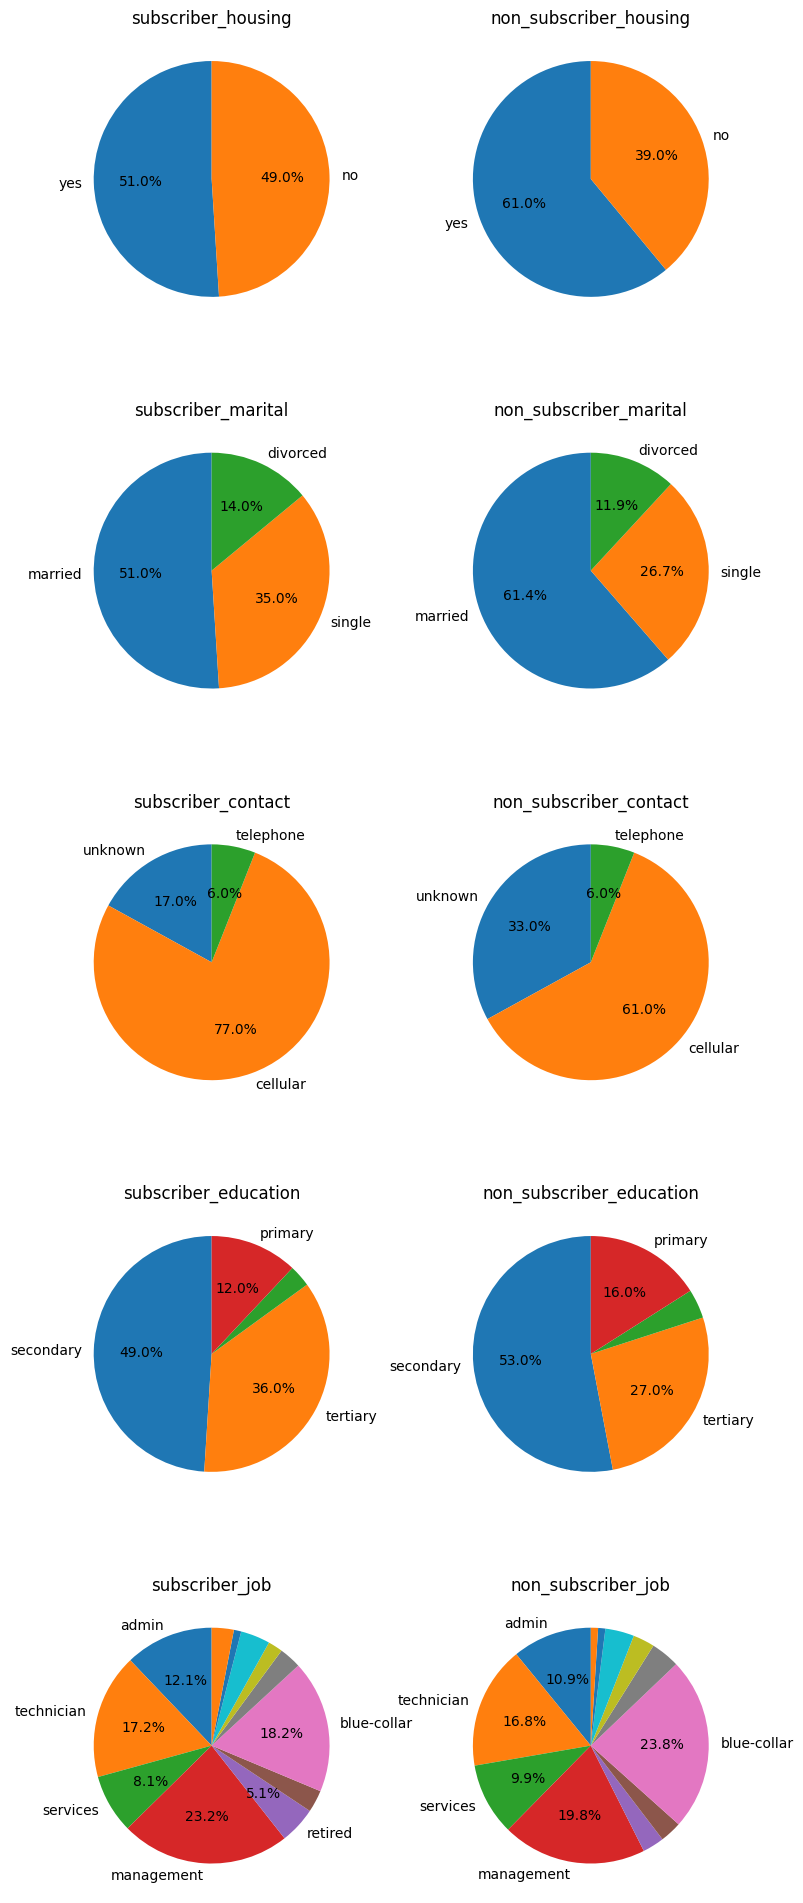

In [79]:
cols_to_plot = [top_feature for top_feature in top_features if top_feature not in ['month', 'day']]
num_cols = len(cols_to_plot)
fig, axes = plt.subplots(num_cols, 2, figsize=(8, 4*num_cols))
plt.tight_layout(pad=3)
for i, col in enumerate(cols_to_plot):
    for j in [0, 1]:
        ax = axes[i, j]
        counts_df = concat_counts_df(df1=subscribers_df, df1_name="subscriber",
                                    df2=non_subscribers_df, df2_name="non_subscriber",
                                    column=col)
        values = counts_df.values[j]
        labels = [col if val >= 0.05 else "" for col, val in zip(counts_df.columns, values)]
        plot_pies(values=values,
                  labels=labels,
                  ax=ax,
                  title=counts_df.index[j],
                  autopct=lambda x: ('%1.1f%%' % x) if x > 5 else '',
                  sort_values=False)

1. housing: has a housing loan? (binary)<br>
Almost half of the subscribers (49%) do not have a housing loan while less proportion of non-subscribers (39%) are without a housing loan. This indicates that customers without a housing loan are more likely to subscribe.

2. marital : marital status (categorical)<br>
Proportionally fewer married customers subscribed, whereas single and divorced subscribers account for almost half of all subscribers. Based on this, our client can put more emphasis on these groups while devising offerings that married customers would be interested in.

3. contact: contact communication type (categorical)<br>
77% of subscribers were contacted at their cellular phone, which was 16% point more than the non-subscriber group, which signifies that customers are more likely to subscribe when cellular is the means of contact. Thus it could be worth making an effort to obtain cellular phone numbers (and potentially other information that might be helpful) from the customers to attract more subscribers.

4. education (categorical)<br>
As a whole, subscribers are more educated than non-subscribers, so our client can try to offer services that less educated people might be interested in, or strengthen offerings for more educated customers. In terms of the ratios between subscribers and non-subscribers, customers with tertiary education are most likely to subscribe (i.e. 9% point difference between the subscriber and non-subscriber groups with tertiary education; 36% vs. 27%).

5. job : type of job (categorical)<br>
The biggest gap between subscribers and non-subscribers comes from blue-collar customers - blue-collar customers account for 24% of non-subscribers, while they only account for 18% of subscribers. This means that blue-collar customers are less likely to subscribe. On the contrary, customers with management jobs are more likely to subscribe, which our client can focus more on (i.e. customers with management jobs account for 23% of the subscriber group while only accounting for 20% of the non-subscriber group).

In [80]:
(subscribers_df['marital'].value_counts() / ( subscribers_df['marital'].value_counts() + non_subscribers_df['marital'].value_counts() )).sort_values(ascending=False)

single      0.094315
divorced    0.082751
married     0.060609
Name: marital, dtype: float64

In [81]:
(subscribers_df['housing'].value_counts() / ( subscribers_df['housing'].value_counts() + non_subscribers_df['housing'].value_counts() )).sort_values(ascending=False)

no     0.089674
yes    0.060921
Name: housing, dtype: float64

In [82]:
(subscribers_df['education'].value_counts() / ( subscribers_df['education'].value_counts() + non_subscribers_df['education'].value_counts() )).sort_values(ascending=False)

tertiary     0.091826
secondary    0.067546
unknown      0.062704
primary      0.056300
Name: education, dtype: float64

In [83]:
(subscribers_df['job'].value_counts() / ( subscribers_df['job'].value_counts() + non_subscribers_df['job'].value_counts() )).sort_values(ascending=False)

student          0.156489
retired          0.105080
unemployed       0.086957
management       0.082782
self-employed    0.079208
admin            0.078296
technician       0.072534
unknown          0.072340
entrepreneur     0.062633
services         0.060870
blue-collar      0.057018
housemaid        0.048758
Name: job, dtype: float64

##### <b>5-5. Analyze day and month variables</b>

Last but not least, analyze variables with time elements, that is the day and month variables. Look at the counts as well as the subscriber to non-subscriber ratio for each day and each month to understand what day of the month and what month of the year attracted more customers.

##### <b>5-5-1. Day</b>

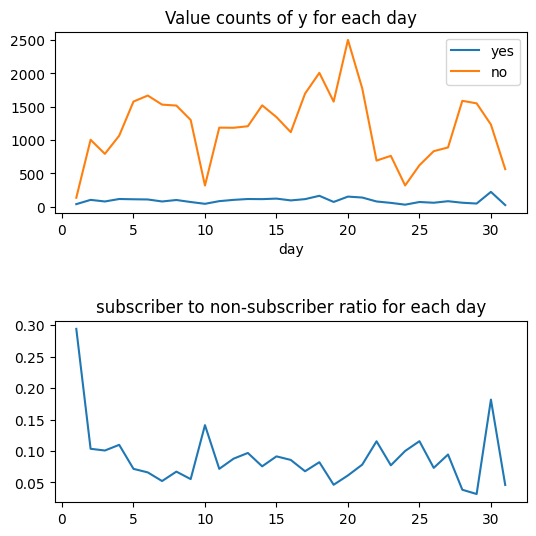

In [84]:
plot_timeseries(data=non_numeric_df, 
                time_variable="day",
                group_col="y",
                group_vals=["yes", "no"],
                figsize=(6, 6),
                plot_ratio_for_binary_class=True,
                class_names=["subscriber", "non-subscriber"])

In [85]:
print("Subscriber and non-subscriber counts on the day of 1:\n",
    non_numeric_df[non_numeric_df.day==1]['y'].value_counts(), "\n")

print("Subscriber and non-subscriber counts on the day of 10:\n",
      non_numeric_df[non_numeric_df.day==10]['y'].value_counts(), "\n")

print("Subscriber and non-subscriber counts on the day of 30:\n",
      non_numeric_df[non_numeric_df.day==30]['y'].value_counts())

Subscriber and non-subscriber counts on the day of 1:
 no     136
yes     40
Name: y, dtype: int64 

Subscriber and non-subscriber counts on the day of 10:
 no     319
yes     45
Name: y, dtype: int64 

Subscriber and non-subscriber counts on the day of 30:
 no     1233
yes     224
Name: y, dtype: int64


Some days like the 1st, 10th, and 30th had higher subscriber to non-subscriber ratios. Relatively smaller numbers of customers were contacted but larger proportions of them subscribed on those days. Thus, it would be worth looking into it further why this was the case in order to improve the success rate for marketing calls made to customers, but this would require more data from marketing or other departments.

##### <b>5-5-2. Month</b>

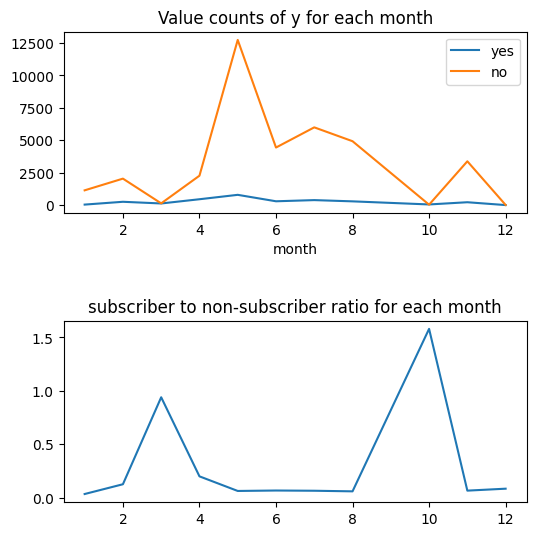

In [86]:
plot_timeseries(data=non_numeric_df, 
                time_variable="month",
                group_col="y",
                group_vals=["yes", "no"],
                figsize=(6, 6),
                plot_ratio_for_binary_class=True,
                class_names=["subscriber", "non-subscriber"])

In [87]:
print("Subscriber and non-subscriber counts in March:\n",
      non_numeric_df[non_numeric_df.month==3]['y'].value_counts(), "\n")

print("Subscriber and non-subscriber counts in October:\n",
      non_numeric_df[non_numeric_df.month==10]['y'].value_counts(), "\n")

print("Subscriber and non-subscriber counts in May:\n",
      non_numeric_df[non_numeric_df.month==5]['y'].value_counts())

Subscriber and non-subscriber counts in March:
 no     133
yes    125
Name: y, dtype: int64 

Subscriber and non-subscriber counts in October:
 yes    49
no     31
Name: y, dtype: int64 

Subscriber and non-subscriber counts in May:
 no     12741
yes      791
Name: y, dtype: int64


March and October had the highest subscriber to non-subscriber ratios and the ratio was even greater than 1.0 in October, meaning there were more subscribers than non-subscribers in October.

On the other hand, there were more than 13000 calls made only to get 791 customers to subscribe in May.

To further investigate these, we would need to work with Marketing and Call Center to better understand different circumstances in different months.

### <b>6. Conclusion</b>

##### <b>6-1. Prediction accuracy</b>
We were able to train a model that predicts if the customer will subscribe (yes/no) to a term deposit (variable y), and achieved an average accuracy score of 93.5% with 5-fold cross validation.

Also, we analyzed each feature to identify 1) customer segments that our client should prioritize and 2) more important features to focus on as summarized as follows.

##### <b>6-2. Customer segments</b>
1. Age: Although most customers were younger than 60, the subscription/success rate was only 7%, as opposed to 39% for customers over 60. For this reason, our client can focus more on older customers as they are more likely to subscribe.

2. Housing loan: Customers without a housing loan were more likely to subscribe.

3. Marital status: Single and divorced customers were more likely to subscribe.

4. Education level: Customers with tertiary education were most likely to subscribe.

5. Job type: Customers with management jobs were more likely to subscribe while blue-collar customers were less likely to subscribe. Our client can choose to focus more on customers with management jobs and put less emphasis on attracting blue-collar customers based on this.

##### <b>6-3. Important features</b>
The following features were found to be the most important based on feature importance scores from the XGBoost classifier:<br>
<i>['month', 'housing', 'marital', 'contact', 'education', 'job', 'day']</i>
* Features other than these had feature importance scores smaller than 0.05.

day and month were two of the top features but we would need more data about marketing efforts made and company/market situations on certain days and months to understand in which particular circumstances customers subscribed more than on other days and months. Any repetitive seasonal patterns, if they exist, should also be taken into account.

##### <b>6-4. Application</b>
The solutions in this project (i.e. predictive machine learning model and feature-wise in-depth analysis) can be applied to business problems in similar contexts, that is a binary classification problem using customer or call center data.
- The solutions would be more applicable if the business problem to solve is relevant in the marketing and banking fields.
- The data used in this project was sourced from a call center but the source of data would not matter too much as long as it contains similar types of information.